# Название проекта:
        
#  Сборный проект. Модуль 2
_____
**Описание исследования.**
    
Вы работаете в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи вашего мобильного приложения. 
Изучите воронку продаж. Узнайте, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?
После этого исследуйте результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясните, какой шрифт лучше.
Создание двух групп A вместо одной имеет определённые преимущества. Если две контрольные группы окажутся равны, вы можете быть уверены в точности проведенного тестирования. Если же между значениями A и A будут существенные различия, это поможет обнаружить факторы, которые привели к искажению результатов. Сравнение контрольных групп также помогает понять, сколько времени и данных потребуется для дальнейших тестов.
В случае общей аналитики и A/A/B-эксперимента работайте с одними и теми же данными. В реальных проектах всегда идут эксперименты. Аналитики исследуют качество работы приложения по общим данным, не учитывая принадлежность пользователей к экспериментам.


_____
**Цель исследования.**
    
Отработать знания полученные во 2-м модуле.
    
_____
**Задачи исследования.**

- Подготовить данные для исследования, изучить типы, пропуски и дубликаты;
- Провести исследовательский анализ данных, построить графики;
- Определить актуальный временной промежуток для анализа, с предпосылкой запаздывание получения данных;
- Построить и изучить воронку событий;
- Изучить результаты эксперимента.
_____
**Исходные данные.**
    
Исходные данные представлены файлом с логами событий мобильного приложения (с разбиением на тестовые группы).

**Таблица logs_exp:**

- EventName — название события;;
- DeviceIDHash — уникальный идентификатор пользователя;
- EventTimestamp — время события;
- ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.
______
**Данное исследование разделим на несколько частей.**
    
[***Часть 1. Изучение данных из файла:***](#1)
* [1. Изучение файлов с данными, получение общей информации, загрузка библиотек.](#11)
* [2. Проверка дубликатов и типов данных.](#12)

[***Часть 2. Изучение и проверка данных:***](#2)
* [1. Исследовательский анализ.](#21)
* [2. Определение горизонта анализа.](#22)
* [3. Проверка нового горизонта.](#23)
    
[***Часть 3. Воронка событий.***](#3)
* [1. Определение частоты событий и распределений по пользователям.](#31)
* [2. Определение порядка событий в приложении.](#32)
* [3. Расчет конверсии.](#33)
* [4. Выводы по конверсии.](#34)

[***Часть 4. Изучение результатов эксперимента.***](#4)
* [1. Подготовка к статистическому анализу.](#41)
* [2. Создание функции. Анализ А/А-групп.](#42)
* [3. Работа с группой В.](#43)
* [4. Выводы по уровню значимости.](#44)

[***Часть 5. Общие выводы.***](#5)

<a id='1'></a>
## Изучение и подготовка данных

- Замените названия столбцов на удобные для вас;
- Проверьте пропуски и типы данных. Откорректируйте, если нужно;
- Добавьте столбец даты и времени, а также отдельный столбец дат;

<a id='11'></a>
### Импортируем планируемые к применению в проекте библиотеки

In [118]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import numpy as np
import scipy.stats as st
import plotly.express as px
from plotly import graph_objects as go
import math

import warnings

warnings.filterwarnings('ignore')

### Открываем файлы

In [119]:
df = pd.read_csv('/datasets/logs_exp.csv', sep='\s+')

<a id='12'></a>
### Проверяем датасет

In [120]:
df.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [121]:
df.columns = ['event', 'device_id', 'timestamp', 'exp']

In [122]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   event      244126 non-null  object
 1   device_id  244126 non-null  int64 
 2   timestamp  244126 non-null  int64 
 3   exp        244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [123]:
round((df.isna().mean()*100),2)

event        0.0
device_id    0.0
timestamp    0.0
exp          0.0
dtype: float64

In [124]:
df['event'] = df['event'].str.lower()

In [125]:
# проверяем на полные дубликаты

df.duplicated().sum()

413

In [126]:
df[df.duplicated()].head(10)

,event,device_id,timestamp,exp
453,mainscreenappear,5613408041324010552,1564474784,248
2350,cartscreenappear,1694940645335807244,1564609899,248
3573,mainscreenappear,434103746454591587,1564628377,248
4076,mainscreenappear,3761373764179762633,1564631266,247
4803,mainscreenappear,2835328739789306622,1564634641,248
5641,cartscreenappear,4248762472840564256,1564637764,248
5875,paymentscreensuccessful,6427012997733591237,1564638452,248
7249,offersscreenappear,7224691986599895551,1564641846,246
8065,cartscreenappear,8189122927585332969,1564643929,248
9179,mainscreenappear,2230705996155527339,1564646087,246


In [127]:
# выявили дубликаты, изучим несколько кейсов по device_id

df.query('device_id == 5613408041324010552').head(5)

,event,device_id,timestamp,exp
452,mainscreenappear,5613408041324010552,1564474784,248
453,mainscreenappear,5613408041324010552,1564474784,248
104383,mainscreenappear,5613408041324010552,1564857690,248
104628,mainscreenappear,5613408041324010552,1564858279,248
104637,mainscreenappear,5613408041324010552,1564858297,248


In [128]:
df.query('device_id == 434103746454591587').head(5)

,event,device_id,timestamp,exp
3572,mainscreenappear,434103746454591587,1564628377,248
3573,mainscreenappear,434103746454591587,1564628377,248
16932,mainscreenappear,434103746454591587,1564659464,248
17876,mainscreenappear,434103746454591587,1564660956,248
18333,mainscreenappear,434103746454591587,1564661640,248


In [129]:
df.query('device_id == 1694940645335807244').head(5)

,event,device_id,timestamp,exp
2345,mainscreenappear,1694940645335807244,1564609892,248
2346,cartscreenappear,1694940645335807244,1564609897,248
2348,cartscreenappear,1694940645335807244,1564609899,248
2349,paymentscreensuccessful,1694940645335807244,1564609899,248
2350,cartscreenappear,1694940645335807244,1564609899,248


Как видим по первым двум кейсам, приложение дублирует фиксацию открытия главной страницы, записывая события дважды в одно и тоже время, возможно это ошибка при записи лога, либо двойное обновление страницы при загрузке. 
В третьем же случае у нас происходит 3 события в 1 время, открытие корзины, успешная оплата, открытие корзины. 
Является ли это событие дублером и возможной ошибкой, как в первых двух случаях? Вполне возможно. Кажется сомнительным быстродействие приложения, что сразу после оплаты открывается корзина в рамках 1 секунду. 

Также, помимо главного экрана и корзины, в дублях фигурирует событие: paymentscreensuccessful

In [130]:
df.query('device_id == 6427012997733591237').head(15)

,event,device_id,timestamp,exp
677,cartscreenappear,6427012997733591237,1564504613,248
977,mainscreenappear,6427012997733591237,1564564037,248
982,cartscreenappear,6427012997733591237,1564564212,248
1010,mainscreenappear,6427012997733591237,1564567013,248
1011,mainscreenappear,6427012997733591237,1564567054,248
1014,offersscreenappear,6427012997733591237,1564567111,248
1333,cartscreenappear,6427012997733591237,1564581583,248
1334,mainscreenappear,6427012997733591237,1564581608,248
1474,mainscreenappear,6427012997733591237,1564586570,248
1477,mainscreenappear,6427012997733591237,1564586594,248


Дважды (индекс 5874 и 5875) проходит событие успешной оплаты в одну и ту же секунду. 

Таким образом, удалим дубликаты с опцией first (по умолчанию), то есть оставим первое вхождение дубликатного значения.
Также сбросим индексы.

In [131]:
df = df.drop_duplicates().reset_index(drop=True)
df.duplicated().sum()

0

In [132]:
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
df['date'] = pd.to_datetime(df['datetime']).dt.normalize()

In [133]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   event      243713 non-null  object        
 1   device_id  243713 non-null  int64         
 2   timestamp  243713 non-null  int64         
 3   exp        243713 non-null  int64         
 4   datetime   243713 non-null  datetime64[ns]
 5   date       243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 11.2+ MB


In [134]:
df.head(5)

,event,device_id,timestamp,exp,datetime,date
0,mainscreenappear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,mainscreenappear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,paymentscreensuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,cartscreenappear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,paymentscreensuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


Готово, можно переходить к следующей части.

<a id='2'></a>
## Изучение и проверка данных

<a id='21'></a>
### Исследовательский анализ

- Сколько всего событий в логе?
- Сколько всего пользователей в логе?
- Сколько в среднем событий приходится на пользователя?

In [135]:
# Всего событий

df.count()[0]

243713

In [136]:
# уникальные виды событий

df['event'].unique() 

array(['mainscreenappear', 'paymentscreensuccessful', 'cartscreenappear',
       'offersscreenappear', 'tutorial'], dtype=object)

In [137]:
# количество уникальных пользователей

df['device_id'].nunique()

7551

In [138]:
# расчет среднего числа событий на пользователя

df.count()[1] / df['device_id'].nunique()

32.27559263673685

32 события на 1 пользователя

<a id='22'></a>
### Определение горизонта анализа

- Данными за какой период вы располагаете? Найдите максимальную и минимальную дату. 
- Постройте гистограмму по дате и времени.
- Можно ли быть уверенным, что у вас одинаково полные данные за весь период? Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные».
- Определите, с какого момента данные полные и отбросьте более старые. Данными за какой период времени вы располагаете на самом деле?

In [139]:
df[['date']].min()

date   2019-07-25
dtype: datetime64[ns]

In [140]:
df[['date']].max()

date   2019-08-07
dtype: datetime64[ns]

Минимальная дата 25 июля 2019
Максимальная 7 августа 2019

Построим гистограмму по датам и времени

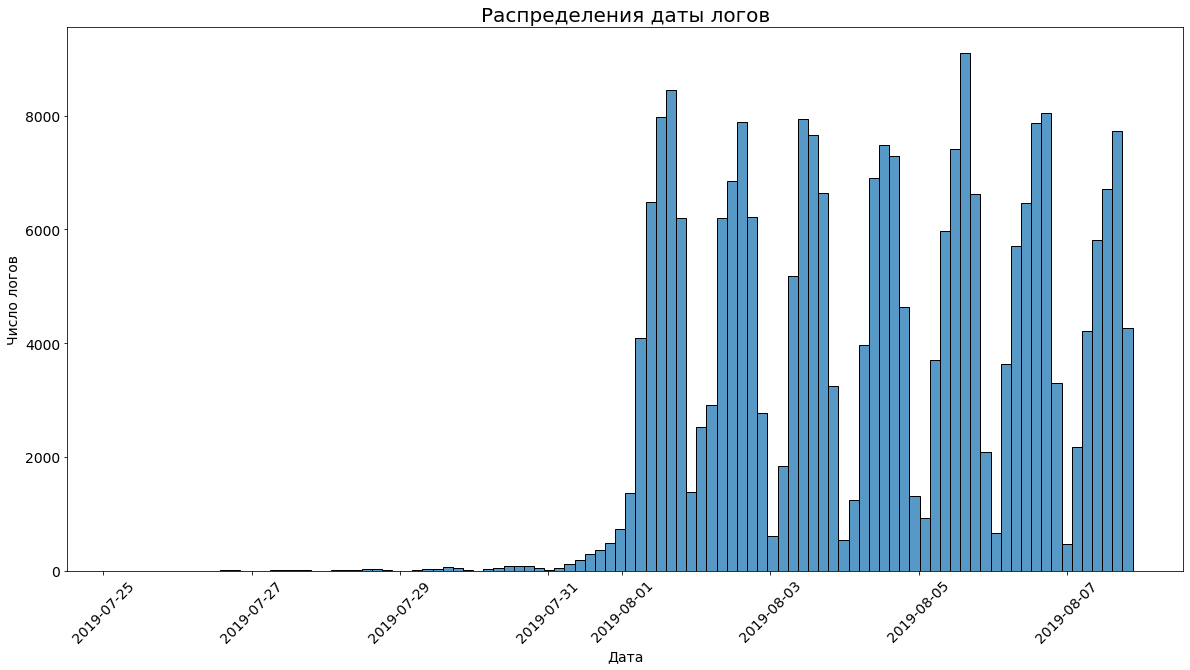

In [141]:
plt.figure(figsize=(20, 10))
sns.histplot(data=df, x="datetime", bins=100)


plt.title('Распределения даты логов', fontsize=20)
plt.ylabel('Число логов', fontsize=14)
plt.xlabel('Дата', fontsize=14)

plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14);

Как видно, наибольшее число логов начинает появляться с 1 августа, таким образом останется 1 неделя данных, вместо двух.
Создадим новый датасет с учетом нового горизонта.

In [142]:
df_new = df[df['date'] > '2019-07-31']

In [143]:
df_new.head()

,event,device_id,timestamp,exp,datetime,date
2826,tutorial,3737462046622621720,1564618048,246,2019-08-01 00:07:28,2019-08-01
2827,mainscreenappear,3737462046622621720,1564618080,246,2019-08-01 00:08:00,2019-08-01
2828,mainscreenappear,3737462046622621720,1564618135,246,2019-08-01 00:08:55,2019-08-01
2829,offersscreenappear,3737462046622621720,1564618138,246,2019-08-01 00:08:58,2019-08-01
2830,mainscreenappear,1433840883824088890,1564618139,247,2019-08-01 00:08:59,2019-08-01


In [144]:
df_new[['date']].min()

date   2019-08-01
dtype: datetime64[ns]

<a id='23'></a>
### Проверка нового горизонта

- Много ли событий и пользователей вы потеряли, отбросив старые данные?
- Проверьте, что у вас есть пользователи из всех трёх экспериментальных групп.

In [145]:
print('Потери из-за сокращения временного промежутка и удаления дубликатов')
print()
print('Потери событий абсолютные:', (df_new.count()[1] - df.count()[1]),'шт.')
print()
print('Потери событий относительные:',  round((df_new.count()[1] / df.count()[1] - 1) * 100, 2)  ,'%')
print()
print('Потери пользователей абсолютные:', (df_new['device_id'].nunique() - df['device_id'].nunique()),'шт.')
print()
print('Потери пользователей относительные:',  round((df_new['device_id'].nunique() / df['device_id'].nunique() - 1) * 100, 2)  ,'%')

Потери из-за сокращения временного промежутка и удаления дубликатов

Потери событий абсолютные: -2826 шт.

Потери событий относительные: -1.16 %

Потери пользователей абсолютные: -17 шт.

Потери пользователей относительные: -0.23 %


Потери событий составили 1.16%.

Потери с учетом первичного удаления дубликатов:

In [146]:
# рассчитаем количество и доли по трем группам, сгруппированные по пользователям

df_new.groupby('device_id').agg({'exp': 'max'}).value_counts()

exp
248    2537
247    2513
246    2484
dtype: int64

In [147]:
df_new.groupby('device_id').agg({'exp': 'max'}).value_counts(normalize=True)

exp
248    0.336740
247    0.333555
246    0.329705
dtype: float64

**Вывод**

Представлены пользователи из трех экспериментальных групп. Значительныех перекосов в пользу одной группы нет.

<a id='3'></a>
## Воронка событий

<a id='31'></a>
### Определение частоты событий и распределений по пользователям

- Посмотрите, какие события есть в логах, как часто они встречаются. 
- Отсортируйте события по частоте.
- Посчитайте, сколько пользователей совершали каждое из этих событий. 
- Отсортируйте события по числу пользователей. 
- Посчитайте долю пользователей, которые хоть раз совершали событие.

In [148]:
# считаем количество событий по видам и определяем долю каждого (события сразу же отсортированы по убыванию частоты и доли)

df_new['event'].value_counts()

mainscreenappear           117328
offersscreenappear          46333
cartscreenappear            42303
paymentscreensuccessful     33918
tutorial                     1005
Name: event, dtype: int64

In [149]:
df_new['event'].value_counts(normalize=True)

mainscreenappear           0.487067
offersscreenappear         0.192343
cartscreenappear           0.175613
paymentscreensuccessful    0.140805
tutorial                   0.004172
Name: event, dtype: float64

Посчитаем число пользователей, которое приходится на каждое событие, а также их долю от общего числа.
Для этого создадим функцию, которая соберет нам датасет.

Входные данные - список с названиями событий и общее уникальное число клиентов

In [150]:
event_list = df_new['event'].unique()
number_of_users = df_new['device_id'].nunique()

users_for_event = []
proportion = []

In [151]:
for i in range(len(event_list)):
    users_for_event.append(df_new[df_new['event'] == event_list[i]]['device_id'].nunique())
    proportion.append(df_new[df_new['event'] == event_list[i]]['device_id'].nunique() / number_of_users)

In [152]:
data = {'event': event_list,
        'number_of_users': users_for_event,
        'proportion': proportion}

df_funnel = pd.DataFrame(data=data)
df_funnel['proportion'] = (df_funnel['proportion'].map(lambda x: round(x, 2)))
df_funnel = df_funnel.sort_values(by='number_of_users', ascending=False) 

df_funnel

,event,number_of_users,proportion
1,mainscreenappear,7419,0.98
2,offersscreenappear,4593,0.61
3,cartscreenappear,3734,0.50
4,paymentscreensuccessful,3539,0.47
0,tutorial,840,0.11


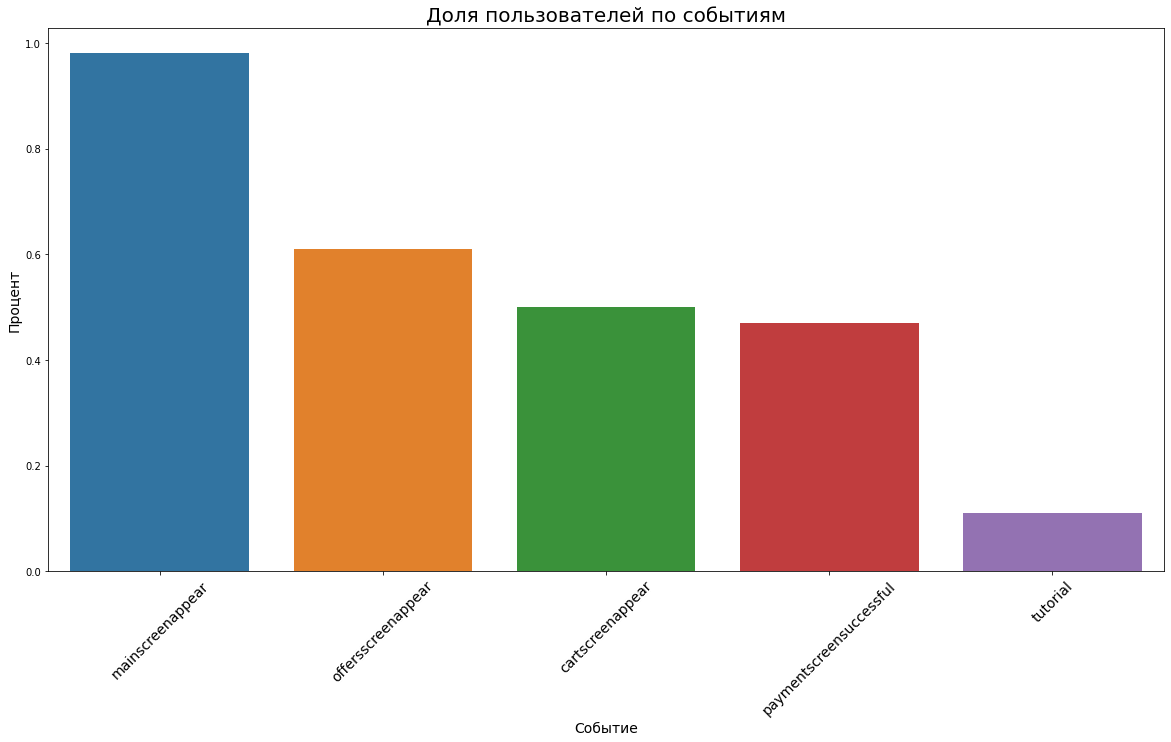

In [153]:
plt.figure(figsize=(20, 10)) 
sns.barplot(x='event', y='proportion', data=df_funnel)


plt.title('Доля пользователей по событиям', fontsize=20)
plt.ylabel('Процент', fontsize=14)
plt.xlabel('Событие', fontsize=14)
plt.xticks(rotation=45, fontsize=14);

**Вывод**

- 98% пользователей попадали на главный экран
- 61% приходило предложение
- 50% открывало корзину
- и 47% успешно оплачивали заказ;
- отдельно стоит отметить окно с обучением в приложении, которое открывало всего 11%

<a id='32'></a>
### Определение порядка событий в приложении

- Предположите, в каком порядке происходят события. 
- Все ли они выстраиваются в последовательную цепочку? Их не нужно учитывать при расчёте воронки.

Предполагаемая схема движения клиентов в приложении на изображении ниже

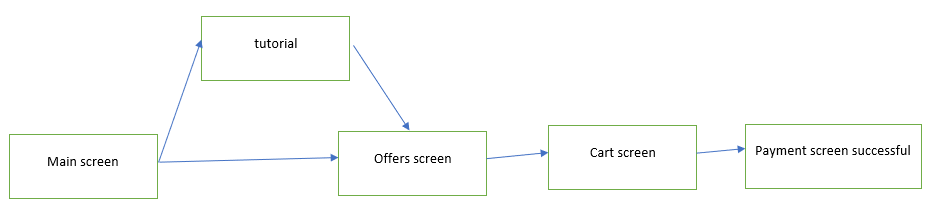

После попадаения на главный экран, часть клиентов может пройти обучение, однако, судя по статистике оно не так востребовано (всего 11% пользователей прошли обучение).

Далее следует экран предложений, на который попадает уже 61% пользователей.
С учетом данных, наибольшие потери идут именно в этом разделе.
Если на главном экране у нас 98% пользователей, то предложение получают уже 61%.
До корзины доходит 50% и оплачивает заказ 47%.

То есть можно сказать, что большинство из тех, кто переходит в корзину - совершают покупку. 
Проблема в том, что почти 40% не получают предложений.

В свою очередь обучение мы не будем учитывать при дальнейших расчетах.

<a id='33'></a>
### Расчет конверсии

- По воронке событий посчитайте, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). То есть для последовательности событий A → B → C посчитайте отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B.

In [154]:
df_funnel

,event,number_of_users,proportion
1,mainscreenappear,7419,0.98
2,offersscreenappear,4593,0.61
3,cartscreenappear,3734,0.50
4,paymentscreensuccessful,3539,0.47
0,tutorial,840,0.11


In [155]:
# удаляем событие обучения

df_funnel = df_funnel.drop(0)
df_funnel

,event,number_of_users,proportion
1,mainscreenappear,7419,0.98
2,offersscreenappear,4593,0.61
3,cartscreenappear,3734,0.50
4,paymentscreensuccessful,3539,0.47


In [156]:
# создаем список с расчетами, начиная со 2 строки (т.к. первую мы ни на что не делим)

proportion_to_prev = []
proportion_to_prev.append(1)

for i in range(2, 5):
    proportion_to_prev.append(df_funnel['number_of_users'][i] / df_funnel['number_of_users'][i - 1])
    
proportion_to_prev

[1, 0.6190861302062273, 0.8129762682342695, 0.9477771826459561]

In [157]:
df_funnel['proportion_to_prev'] = proportion_to_prev
df_funnel['proportion_to_prev'] = (df_funnel['proportion_to_prev'].map(lambda x: round(x, 2)))
df_funnel

,event,number_of_users,proportion,proportion_to_prev
1,mainscreenappear,7419,0.98,1.00
2,offersscreenappear,4593,0.61,0.62
3,cartscreenappear,3734,0.50,0.81
4,paymentscreensuccessful,3539,0.47,0.95


In [158]:
fig = go.Figure(
    go.Funnel(
        y=df_funnel['event'],
        x=df_funnel['number_of_users'],
        textinfo = "value+percent initial+percent previous"
    )
)
fig.show() 

<a id='34'></a>
### Выводы по конверсии

- На каком шаге теряете больше всего пользователей?
- Какая доля пользователей доходит от первого события до оплаты?

**Вывод**

Наибольшие потери конверсии выходят на шаге 2, а именно offersscreenappear.
При этом, с учетом потерь в размере 38,1% на шаге 2, общая конверсия до оплаты достигает 47,7%, что достаточно неплохо.

При этом следует разобраться, почему не все пользователи доходят до шага 2, возможно им просто не падает предложение из-за бага в приложении, либо же эти пользователи сразу же закрывают приложение и более им не пользуются.

Однако для подобной аналитике понадобится больше данных (например сравнение времени первого открытия приложения и закрытия в разрезе подобных пользователей, без шага 2).

<a id='4'></a>
## Изучение результатов эксперимента

<a id='41'></a>
### Подготовка к статистическому анализу

- Сколько пользователей в каждой экспериментальной группе?
- Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверьте, находят ли статистические критерии разницу между выборками 246 и 247.

Вернемся к датасету df_new с обрезанными датами.

In [159]:
# рассчитаем количество пользователей в каждой группе и создаем датасет для добавления далее

exp_total = df_new.pivot_table(columns = 'exp', values = 'device_id', aggfunc = 'nunique').reset_index()
exp_total.columns = ['event', 246, 247, 248] 
exp_total.loc[0, 'event'] = 'total'
exp_total

,event,246,247,248
0,total,2484,2513,2537


С учетом, что в шаге 4.2 от нас потребуется создать функцию по проверке статистической значимости результатов в 4 парах (А1/А2, А1/В, А2/В и (А1 + А2) / В), то в шаге 4.1 создадим датасет с разбивкой числа уникальных пользователей по группам и событиям, а в шаге 4.2 уже создадим функцию и вспользуемся ею на всех событиях.
Дополнительно сразу же создадим комбинированную группу, состоящую из двух А групп (246 и 247). 

Также зададим переменную aplha, в которой возьмем уровень значимости в размере 0.05 и переменные для каждого события.

Переменные для групп также создадим, чтобы не путаться, что у нас обозначает каждая из групп.

In [160]:
alpha = 0.05
tutorial = 'tutorial'
main = 'mainscreenappear'
offer = 'offersscreenappear'
cart = 'cartscreenappear'
pay = 'paymentscreensuccessful'
total = 'total'
a1 = 246
a2 = 247
b = 248
combined = 'combined'

In [161]:
df_exp = df_new.pivot_table(index = 'event', columns ='exp', values = 'device_id', aggfunc = 'nunique').reset_index()
df_exp = df_exp.append(exp_total).sort_values(by=a1, ascending = False)
df_exp = df_exp.set_index('event')
df_exp['combined'] = df_exp[246] + df_exp[247]
df_exp

,246,247,248,combined
event,,,,
total,2484,2513,2537,4997
mainscreenappear,2450,2476,2493,4926
offersscreenappear,1542,1520,1531,3062
cartscreenappear,1266,1238,1230,2504
paymentscreensuccessful,1200,1158,1181,2358
tutorial,278,283,279,561


In [163]:
df_exp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6 entries, total to tutorial
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   246       6 non-null      int64
 1   247       6 non-null      int64
 2   248       6 non-null      int64
 3   combined  6 non-null      int64
dtypes: int64(4)
memory usage: 240.0+ bytes


<a id='42'></a>
### Создание функции. Анализ А/А-групп

- Выберите самое популярное событие.
- Посчитайте число пользователей, совершивших это событие в каждой из контрольных групп.
- Посчитайте долю пользователей, совершивших это событие.
- Проверьте, будет ли отличие между группами статистически достоверным.
- Проделайте то же самое для всех других событий (удобно обернуть проверку в отдельную функцию). 
- Можно ли сказать, что разбиение на группы работает корректно?

Создадим функцию по алгоритму выше.
Для проверки статистической значимости используем z-тест, который исследует разницу между пропорциями, наблюдаемыми в выборках.

За значение trials берется общее число уникальных пользователей в группе, за значения suc берется одно из 5 событий, в зависимости от переменной в функции.

**Гипотезы**
- Н0 - Между долями отсутствует существенная разница.
- Н1 - Между долями есть существенная разница.

In [172]:
def z_test (data, group1, group2, event, alpha):
 
    g1_trial = data.loc[total, group1]
    g2_trial = data.loc[total, group2]
    g1_suc = data.loc[event, group1]
    g2_suc = data.loc[event, group2]
 
    # пропорция успехов в первой группе:
    p1 = g1_suc/g1_trial
 
    # пропорция успехов во второй группе:
    p2 = g2_suc/g2_trial
 
    # пропорция успехов в комбинированном датасете:
    p_combined = (g1_suc + g2_suc) / (g1_trial + g2_trial)
 
    # разница пропорций в датасетах
    difference = p1 - p2 
 
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / math.sqrt(p_combined * (1 - p_combined) * (1/g1_trial + 1/g2_trial))
 
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)
 
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('Cобытие {}'.format(event))
    
    print('Доля группы {} = {:.3f}'.format(group1, p1))
    print('Доля группы {} = {:.3f}'.format(group2, p2))
    
    print()
    
    print('p-значение: {:.3f}'.format(p_value))
    
    print()
 
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')

In [174]:
# Протестируем, что все работает на примере двух групп А, события cartscreenappear и нашей переменной с альфой

z_test(df_exp, a1, a2, event = cart, alpha=alpha)

Cобытие cartscreenappear
Доля группы 246 = 0.510
Доля группы 247 = 0.493

p-значение: 0.229

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Отлично, теперь пробежимся циклом, который будет в event в функции подставлять различные события по порядку из списка.

In [175]:
# создаем список

event_list = [main, offer, cart, pay, tutorial]
event_list

['mainscreenappear',
 'offersscreenappear',
 'cartscreenappear',
 'paymentscreensuccessful',
 'tutorial']

In [176]:
# создаем цикл

for event in event_list:
    z_test(df_exp, a1, a2, event, alpha=alpha)
    print()

Cобытие mainscreenappear
Доля группы 246 = 0.986
Доля группы 247 = 0.985

p-значение: 0.757

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Cобытие offersscreenappear
Доля группы 246 = 0.621
Доля группы 247 = 0.605

p-значение: 0.248

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Cобытие cartscreenappear
Доля группы 246 = 0.510
Доля группы 247 = 0.493

p-значение: 0.229

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Cобытие paymentscreensuccessful
Доля группы 246 = 0.483
Доля группы 247 = 0.461

p-значение: 0.115

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Cобытие tutorial
Доля группы 246 = 0.112
Доля группы 247 = 0.113

p-значение: 0.938

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



**Вывод**

Статистически значимая разница между двумя группами А отсутствует, результаты по всем событиям лежат в пределах alpha.
Таким образом - разбиение на группы работает корректно, можно переходить к анализу А/В-теста. 

<a id='43'></a>
### Работа с группой В

- Аналогично поступите с группой с изменённым шрифтом. Сравните результаты с каждой из контрольных групп в отдельности по каждому событию.
- Сравните результаты с объединённой контрольной группой. Какие выводы из эксперимента можно сделать?


**Гипотезы**
- Н0 - Между долями отсутствует существенная разница.
- Н1 - Между долями есть существенная разница.

####  Сравнение А1 (246) и В (248)

In [177]:
for event in event_list:
    z_test(df_exp, a1, b, event, alpha=alpha)
    print()

Cобытие mainscreenappear
Доля группы 246 = 0.986
Доля группы 248 = 0.983

p-значение: 0.295

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Cобытие offersscreenappear
Доля группы 246 = 0.621
Доля группы 248 = 0.603

p-значение: 0.208

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Cобытие cartscreenappear
Доля группы 246 = 0.510
Доля группы 248 = 0.485

p-значение: 0.078

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Cобытие paymentscreensuccessful
Доля группы 246 = 0.483
Доля группы 248 = 0.466

p-значение: 0.212

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Cобытие tutorial
Доля группы 246 = 0.112
Доля группы 248 = 0.110

p-значение: 0.826

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



####  Сравнение А2 (247) и В (248)

In [179]:
for event in event_list:
    z_test(df_exp, a2, b, event, alpha=alpha)
    print()

Cобытие mainscreenappear
Доля группы 247 = 0.985
Доля группы 248 = 0.983

p-значение: 0.459

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Cобытие offersscreenappear
Доля группы 247 = 0.605
Доля группы 248 = 0.603

p-значение: 0.920

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Cобытие cartscreenappear
Доля группы 247 = 0.493
Доля группы 248 = 0.485

p-значение: 0.579

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Cобытие paymentscreensuccessful
Доля группы 247 = 0.461
Доля группы 248 = 0.466

p-значение: 0.737

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Cобытие tutorial
Доля группы 247 = 0.113
Доля группы 248 = 0.110

p-значение: 0.765

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



####  Сравнение комбинированной А группы и В (248)

In [180]:
for event in event_list:
    z_test(df_exp, combined, b, event, alpha=alpha)
    print()

Cобытие mainscreenappear
Доля группы combined = 0.986
Доля группы 248 = 0.983

p-значение: 0.294

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Cобытие offersscreenappear
Доля группы combined = 0.613
Доля группы 248 = 0.603

p-значение: 0.434

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Cобытие cartscreenappear
Доля группы combined = 0.501
Доля группы 248 = 0.485

p-значение: 0.182

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Cобытие paymentscreensuccessful
Доля группы combined = 0.472
Доля группы 248 = 0.466

p-значение: 0.600

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Cобытие tutorial
Доля группы combined = 0.112
Доля группы 248 = 0.110

p-значение: 0.765

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



**Вывод**

В рамках анализа результатов статистических тестов, ни одна гипотеза об одинаковости долей между группами не была отвергнута. При этом, это работает как при сравнении одиночной группы А с группой В, так и при комбинации двух А групп и сравнении долей с группой В.

Таким образом, в части статистической значимости и верности разбиения групп - эксперимент можно признать удачным. 
Также стоит обозначить, что со статистической точки зрения, различий между группой В и группами А нет.
В абсолютном выражении конверсия по покупке даже упала с 0.47188 (по объединенной А группе) до 0.4655 (на 0.64пп), то есть ожидаемого положительного эффекта от изменения шрифтов в экспериментальной группе не произошло.

<a id='44'></a>
### Выводы по уровню значимости

- Какой уровень значимости вы выбрали при проверке статистических гипотез выше?
- Посчитайте, сколько проверок статистических гипотез вы сделали. При уровне значимости 0.1 каждый десятый раз можно получать ложный результат. Какой уровень значимости стоит применить?
- Если вы хотите изменить его, проделайте предыдущие пункты и проверьте свои выводы.

При анализе статистической значимости был выбран уровень 0.05, при этом было проведено 20 тестов.
Таким образом, даже при достаточно консервативном уровне значимости в 5%, множественный подход добавляет вероятность ошибки.

Так, вероятность не ошибиться ни разу за 20 сравнения составляет:

In [54]:
(1 - 0.05)**20

0.3584859224085419

Всего 36%!

А вероятность ошибиться хоть раз:

In [55]:
1 - (1 - 0.05)**20

0.6415140775914581

Для того, чтобы этого избежать используют поправку на множественную проверку гипотез.

Самым простым способом является поправка Бонферрони, которая просто делит альфу на количество гипотез (в нашем случае а / 20). 
Однако данный способ имеет свои недостатки, так: при увеличении m в результате применения поправки Бонферрони мощность статистической процедуры резко уменьшается — шансы отклонить неверные гипотезы падают.
Таким образом, следует использовать более продвинутый и сложный метод.

Воспользуется пошаговым методом Холма, который предполагает пошаговую проверку с уменьшением знаменателя на 1 на каждом шаге.
При этом p-value всех тестов ранжируются по возрастанию и проверяются от меньшего, к большего. В случае отвергания гипотезы, производится переход на селудющий шаг с уменьшением знаменателя, уменьшающего альфу на 1.
В случае, если гипотеза принимается на каком-либо шаге, то работа с методом останавливается, а эта и все последующие гипотезы принимаются.

В нашем случае мнимальный p-value составляет 0.078, что очевидно больше 0.05 / 20, таким образом, даже с учетом поправочного метода на множественные тесты - проверка гипотез выдерживает статистическое тестирование.

<a id='5'></a>
## Общие выводы

- В рамках подготовки данных были выявлены нерелевантные промежутки логов из-за минимального наличия данных, поэтому актуальный промежуток данных для тестирования составил с 1 августа 2019 года, по 7 августа 2019 года;

- С учетом удаления нерелевантных промежутков и полных дубликатов в событиях, потери в логах составили 1.3%;

- Уникальные пользователи распределены по группах равномерно, от 32,97% до 33,67% на группу;

- Наиболее часто встречаемое событие – Главный экран с долей в событиях в 48,7%, наименее часто встречаемого событие – Обучение с долей в 4%;

- После анализа воронки было выявлено, что наибольшие потери клиентов происходят при переходе от шага с главного экрана, до шага предложений. Так, если шага главного крана достигает 98% от общего числа пользователей в выборке, то до шага предложений доходит только 61% пользователей. Значительных провалов по иным шагам не замечено, конверсия по шагу покупки составляет 47%;

- Статистический анализ, проведенный z-тестов не выявил негатива в части двух групп А, клиенты распределены равномерно и со статистической точки зрения, значимых различий в долях в валидационных группах не обнаружено;

- При проведении сравнения группы В с каждой из групп А, а также комбинированной группой А, также не обнаружено статистически значимого различия в долях, более того, в абсолютном выражении конверсия по покупке в группе В даже упала на 0.64ПП;

- Корректировка уровня значимости с помощью метода Холма (для поправки на множественную проверку гипотез) не меняет результатов тестирования, все значения p-value по тестам находятся выше критического уровня, поэтому нулевая гипотеза о равенстве долей не отвергается.

- С учетом отсутствия статистического различия долей между экспериментальной и тестовыми группами, отсутствия абсолютного роста в конверсии у тестовой группы (и даже незначительного падения на десятые доли %) - предлагается остановить тест и признать его неуспешным. 